In [1]:
from env import *
from calculate import *

In [2]:
# 设置不同的规模比例
min_scale = 5
middle_scale = 10
max_scale = 20

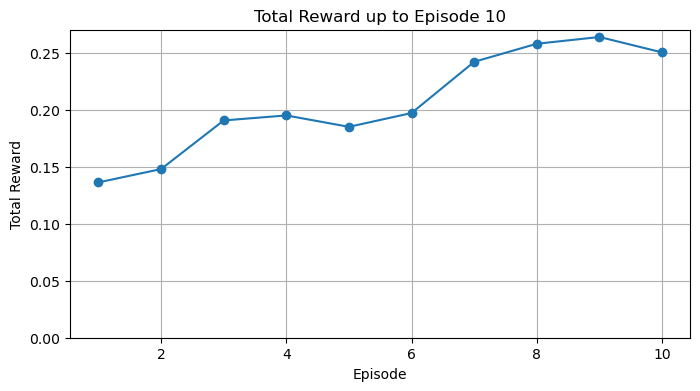

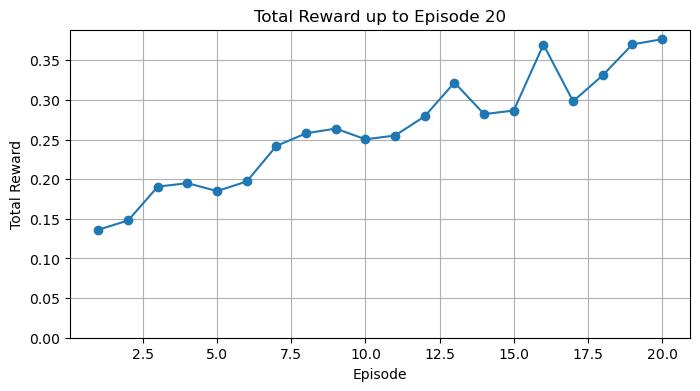

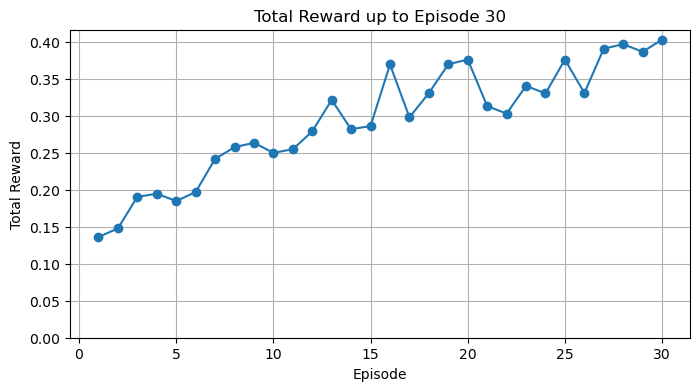

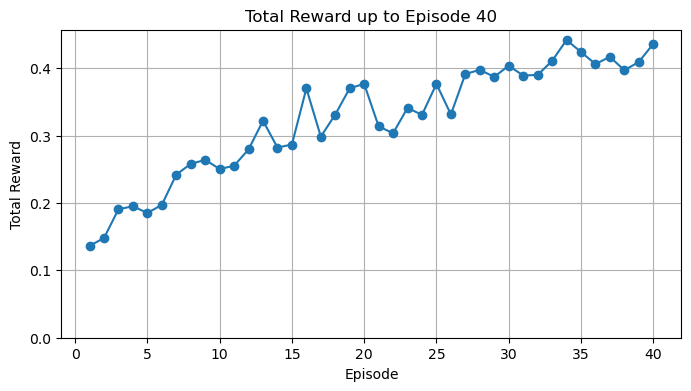

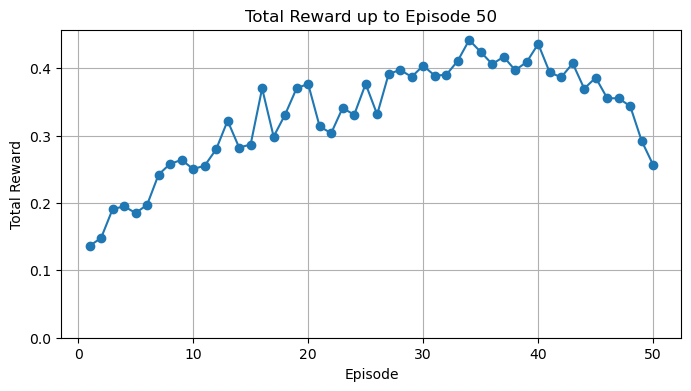

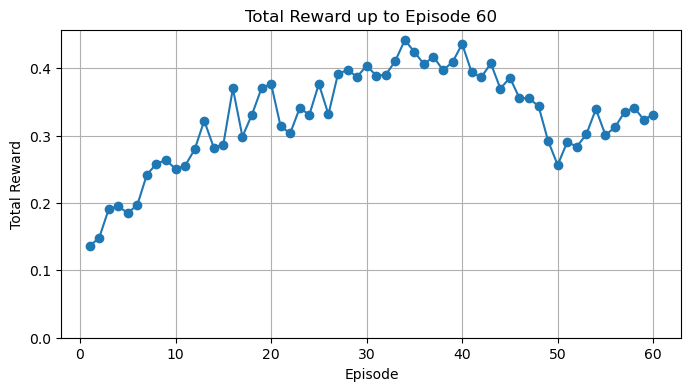

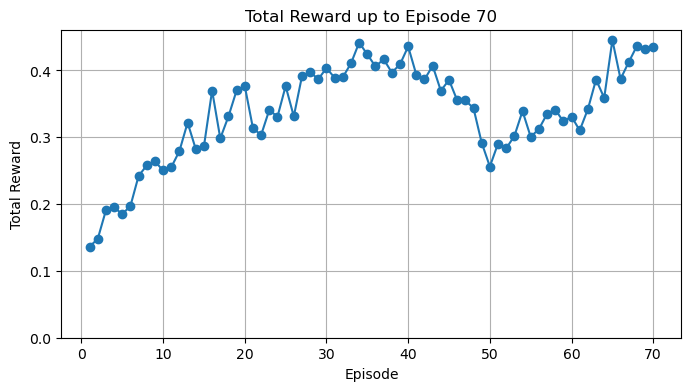

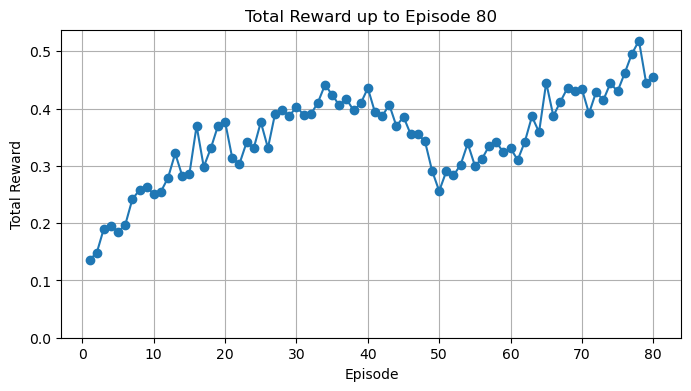

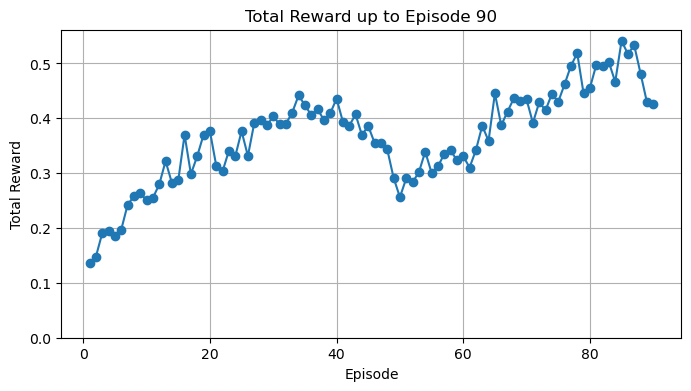

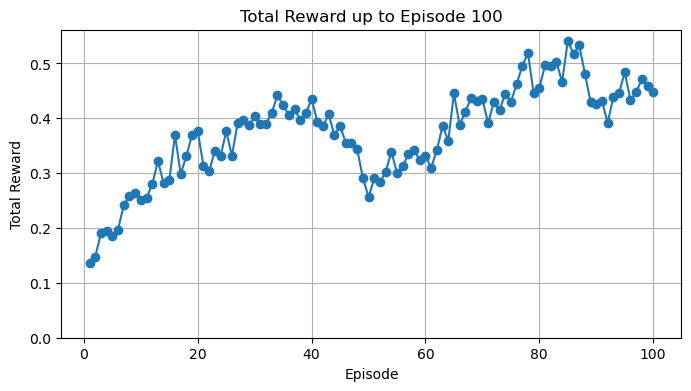

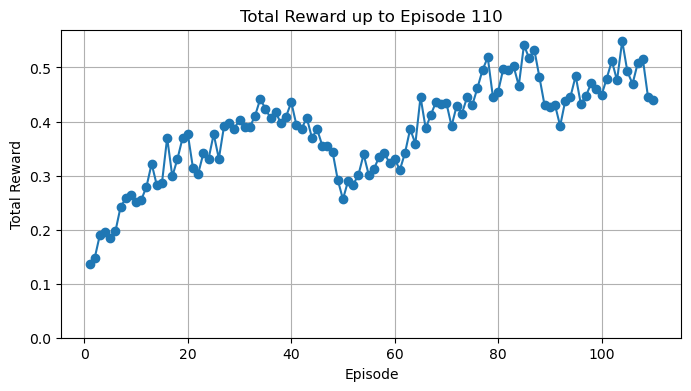

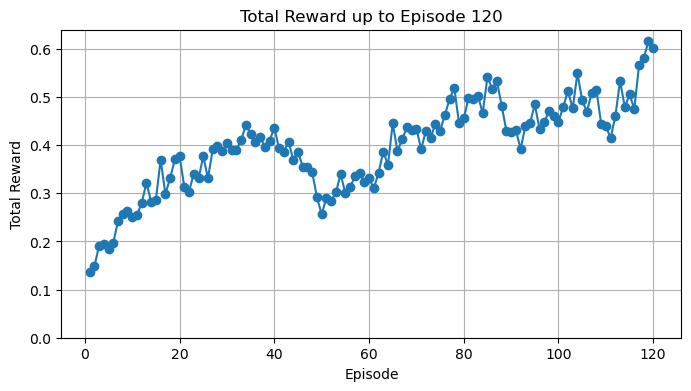

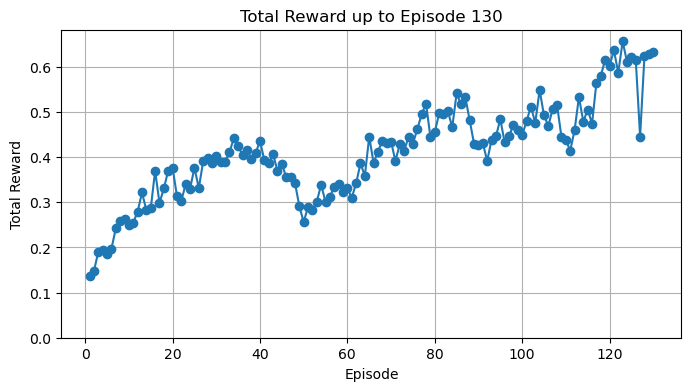

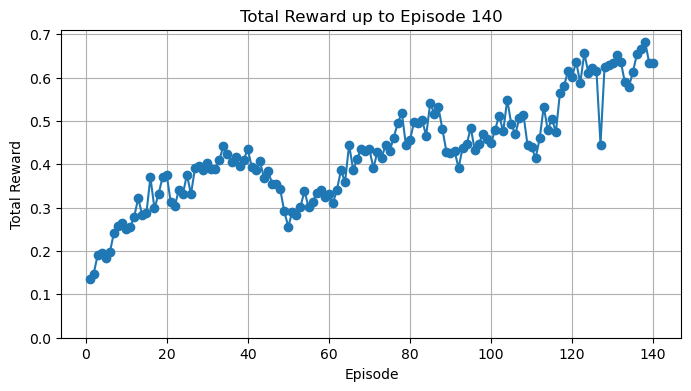

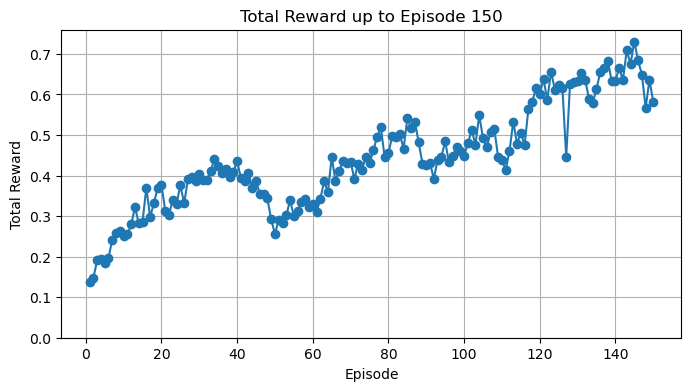

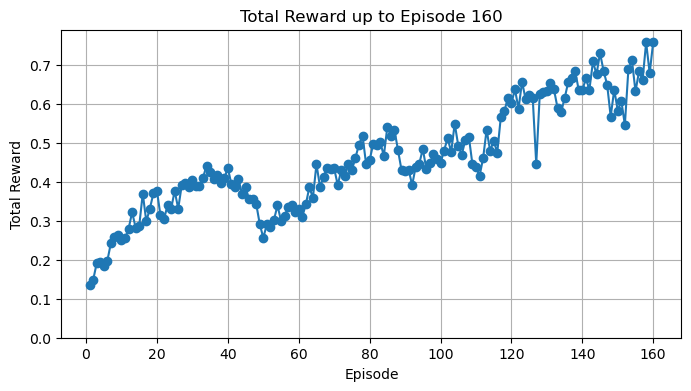

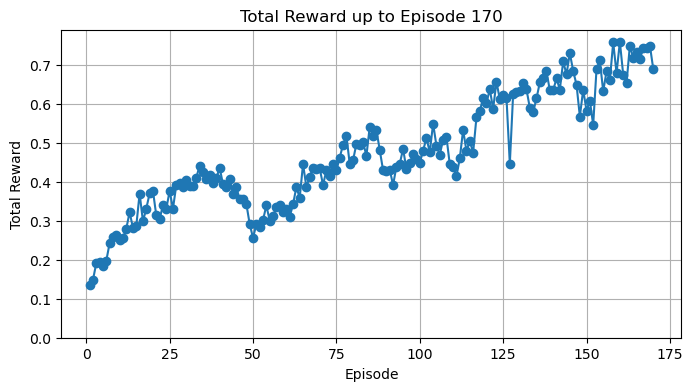

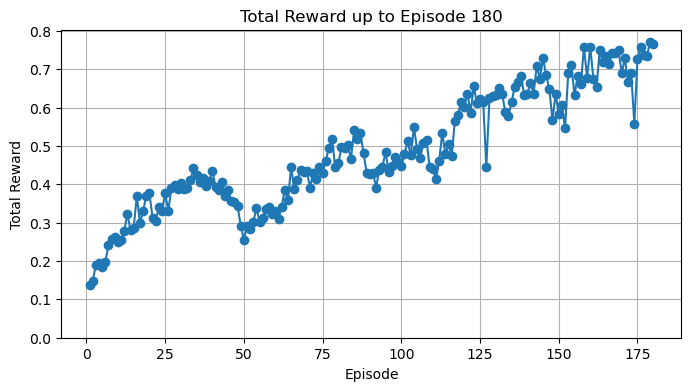

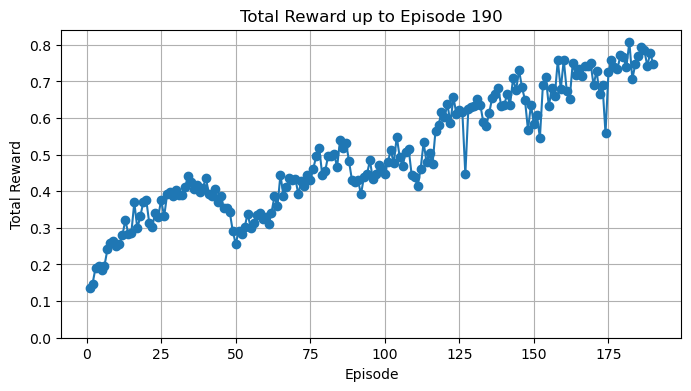

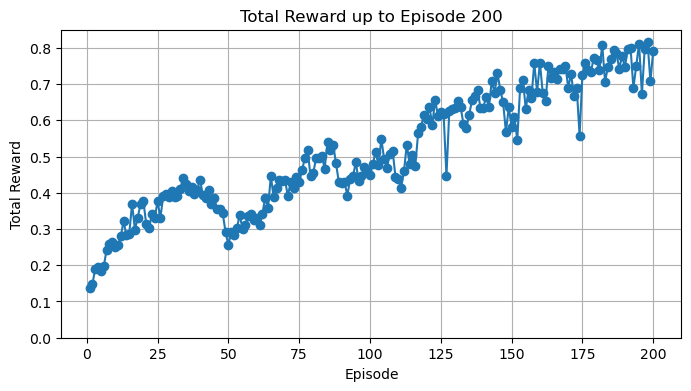

In [3]:
"""
运行 GMP-DRL 优化
"""
from model.dqn import train_dqn
model = train_dqn(max_scale)
log_n()